# 의사결정나무_예측

콘크리트 강도를 예측하는 의사결정나무 모델을 만들고 predict method를 이용하여 예측값을 구하라. 그리고 모델의 mse와 mae를 산출하여 비교하라.   
데이터 : Concrete.CSV(변수: 9개, 자료 수: 1,030개)  
 -.목표변수(strength)  
※ 데이터는 (train(0.6) : test(0.4) )의 비율로 분할 (train_test_split 활용)  
 1. train 데이터: 모델 훈련   
 2. test 데이터: 1에서 개발한 모델의 성능 평가  


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
import matplotlib
# 한글 폰트 적용
matplotlib.rc('font', family = 'Nanumgothic')
# 음수 표시
matplotlib.rc('axes', unicode_minus=False)

from sklearn.tree import export_graphviz
import graphviz

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

In [2]:
df_raw = pd.read_csv('./datasets/Concrete.csv', engine = 'python')
df_raw.head()

,cement,blast_furnace_slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate,age,strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


cement: 시멘트  
blast_furnace_slag: 고로슬래그  
fly_ash: 연소분말  
water: 수분  
superplasticizer: 유동화제  
coarse_aggregate: 굵은골재  
fine_aggregate: 잔골재  
age: 재령

In [3]:
df_raw_y = df_raw['strength']
df_raw_x = df_raw.drop('strength', axis = 1, inplace = False)

In [4]:
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_raw_x, df_raw_y,
                                                               test_size = 0.4, random_state = 1234)

print('train data X size: {}'.format(df_train_x.shape))
print('train data Y size: {}'.format(df_train_y.shape))
print('test data X size: {}'.format(df_test_x.shape))
print('test data Y size: {}'.format(df_test_y.shape))


train data X size: (618, 8)
train data Y size: (618,)
test data X size: (412, 8)
test data Y size: (412,)


In [5]:
tree_uncustomized = DecisionTreeRegressor(random_state = 1234)
tree_uncustomized.fit(df_train_x, df_train_y)

print('Score on training set: {:.3f}'.format(tree_uncustomized.score(df_train_x, df_train_y)))
print('Score on test set: {:.3f}'.format(tree_uncustomized.score(df_test_x, df_test_y)))


Score on training set: 0.996
Score on test set: 0.790


기본 옵션으로 지정된 tree모델에 대해서도 test 데이터가 상당히 잘 맞는 것을 볼 수 있다.   
training set에 대한 score가 1이 아닌 것을 보아 같은 X를 가졌지만 strength 값이 다른 데이터가 있는 것으로 예측할 수 있다.

In [6]:
train_score = []
test_score = []

para_leaf = [n_leaf for n_leaf in range(1, 20)]

for v_min_samples_leaf in para_leaf:
    tree= DecisionTreeRegressor(random_state = 1234, min_samples_leaf = v_min_samples_leaf)
    
    tree.fit(df_train_x, df_train_y)
    train_score.append(tree.score(df_train_x, df_train_y))
    test_score.append(tree.score(df_test_x, df_test_y))
    
df_score_leaf = pd.DataFrame()
df_score_leaf['MinSamplesLeaf'] = para_leaf
df_score_leaf['TrainScore'] = train_score
df_score_leaf['TestScore'] = test_score

df_score_leaf.round(3)

,MinSamplesLeaf,TrainScore,TestScore
0,1,0.996,0.790
1,2,0.978,0.783
2,3,0.959,0.786
3,4,0.943,0.796
4,5,0.934,0.811
5,6,0.920,0.810
6,7,0.909,0.799
7,8,0.900,0.792
8,9,0.877,0.817
9,10,0.868,0.816


더 나은 모델을 위해 잎사귀 노드의 최소 자료 수를 변경해가면서 모델의 성능을 측정해보았다. 잎사귀 노드의 자료 수가 적을 수록 데이터가 과적합되기 쉬운데 표에서도 나타나듯이 노드의 자료수가 19로 가장 클 때 test score가 가장 나쁜 것을 볼 수 있다. leaf node의 자료수는 test score가 가장 좋을 때인 9로 선택한다.

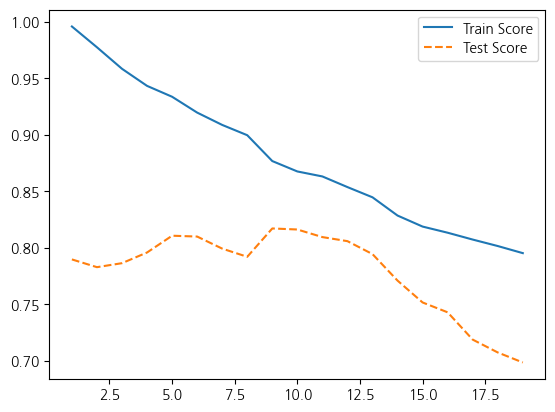

In [7]:
plt.plot(para_leaf, train_score, linestyle = '-', label = 'Train Score')
plt.plot(para_leaf, test_score, linestyle = '--', label = 'Test Score')
plt.legend()

그래프로 본 결과 leaf node의 데이터 수가 많아질수록 test score 즉, 모델의 성능이 급격히 나빠지는 것을 볼 수 있다. 위의 데이터 표와 그래프로 판단했을 때, leaf node의 최소 데이터 수는 9로 설정한다.

In [8]:
!pip install pydot

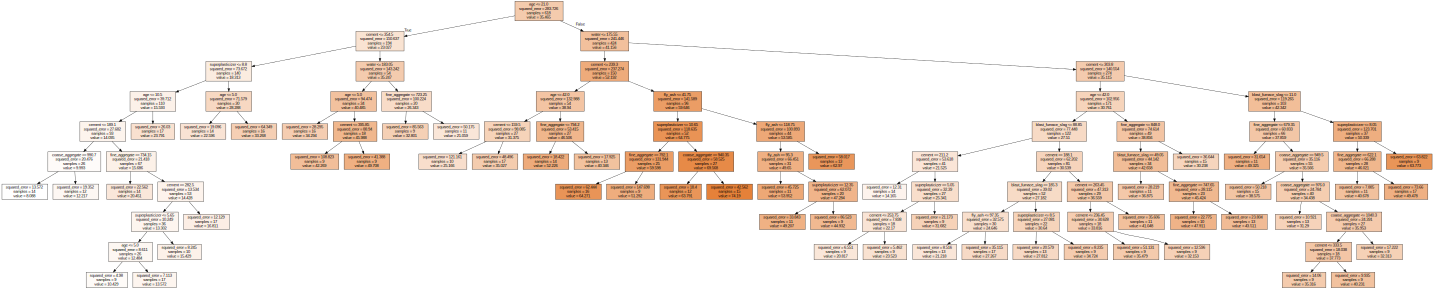

In [9]:
from graphviz import Source
from sklearn import tree
import pydot

v_feature_name = df_train_x.columns

tree_graph = DecisionTreeRegressor(random_state = 1234, min_samples_leaf = 9)
tree_graph.fit(df_train_x, df_train_y)
export_graphviz(tree_graph, out_file = 'concrete_tree_leaf.dot',
               feature_names = v_feature_name, impurity = True, filled= True)
with open('concrete_tree_leaf.dot') as f:
    dot_graph = f.read()

# 크기 조정
pdot = pydot.graph_from_dot_data(dot_graph)
# Access element [0] because graph_from_dot_data actually returns a list of DOT elements.
pdot[0].set_graph_defaults(size = "\"20,20\"")
graph = Source(pdot[0].to_string())
graph

# display(graphviz.Source(dot_graph))

많은 양의 데이터를 처리하다보니 노드 수가 많아진 것을 볼 수 있다.

min_samples_leaf를 9로 설정하고, 분리노드의 최소 자료 수를 변경해보자.

In [10]:
train_score = []
test_score = []

para_split = [n_split * 2 for n_split in range(2, 20)]

for v_min_samples_split in para_split:
    tree= DecisionTreeRegressor(random_state = 1234, min_samples_leaf = 9,
                               min_samples_split = v_min_samples_split)
    
    tree.fit(df_train_x, df_train_y)
    train_score.append(tree.score(df_train_x, df_train_y))
    test_score.append(tree.score(df_test_x, df_test_y))
    
df_score_split = pd.DataFrame()
df_score_split['MinSmaplesSplit'] = para_split
df_score_split['TrainScore'] = train_score
df_score_split['TestScore'] = test_score

df_score_split.round(3)

,MinSmaplesSplit,TrainScore,TestScore
0,4,0.877,0.817
1,6,0.877,0.817
2,8,0.877,0.817
3,10,0.877,0.817
4,12,0.877,0.817
5,14,0.877,0.817
6,16,0.877,0.817
7,18,0.877,0.817
8,20,0.874,0.817
9,22,0.870,0.809


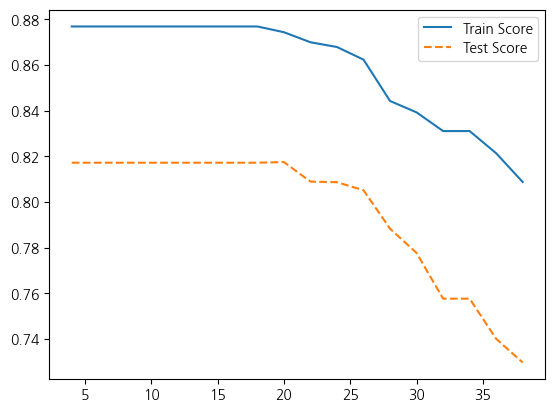

In [11]:
plt.plot(para_split, train_score, linestyle = '-', label = 'Train Score')
plt.plot(para_split, test_score, linestyle = '--', label = 'Test Score')
plt.legend()

분리 노드의 자료수가 20개까지는 test성능에 변화가 없지만 그 이후부터는 계속해서 감소하는 모습을 보여준다. 분리 노드의 자료 수는 20개로 지정한다.

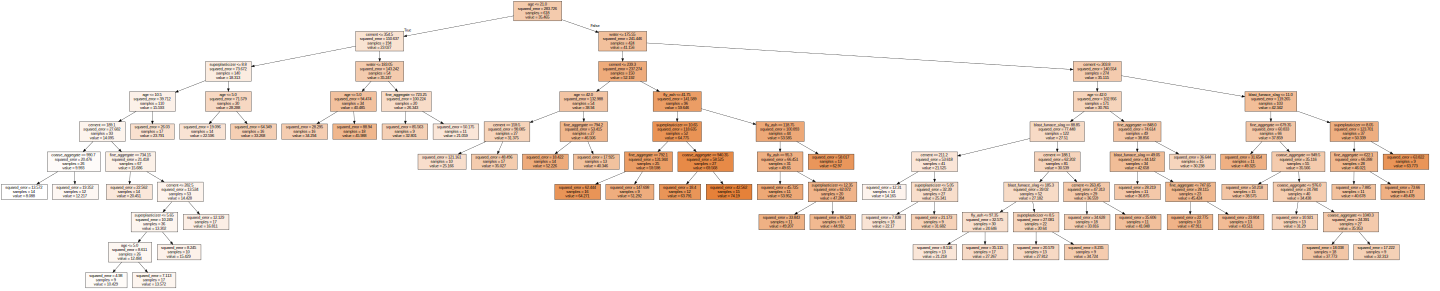

In [12]:
tree_graph = DecisionTreeRegressor(random_state = 1234, min_samples_leaf = 9, min_samples_split = 20)
tree_graph.fit(df_train_x, df_train_y)
export_graphviz(tree_graph, out_file = 'concrete_tree_split.dot',
               feature_names = v_feature_name, impurity = True, filled= True)
with open('concrete_tree_split.dot') as f:
    dot_graph = f.read()

    pdot = pydot.graph_from_dot_data(dot_graph)
# Access element [0] because graph_from_dot_data actually returns a list of DOT elements.
pdot[0].set_graph_defaults(size = "\"20,20\"")
graph = Source(pdot[0].to_string())
graph

마지막으로 깊이에 대한 파라미터를 조절해준다.

In [13]:
train_score = []
test_score = []

para_depth = [depth for depth in range(1, 11)]

for v_max_depth in para_depth:
    tree= DecisionTreeRegressor(random_state = 1234, min_samples_leaf = 9,
                               min_samples_split = 20, max_depth = v_max_depth)
    
    tree.fit(df_train_x, df_train_y)
    train_score.append(tree.score(df_train_x, df_train_y))
    test_score.append(tree.score(df_test_x, df_test_y))
    
df_score_depth = pd.DataFrame()
df_score_depth['Depth'] = para_depth
df_score_depth['TrainScore'] = train_score
df_score_depth['TestScore'] = test_score

df_score_depth.round(3)

,Depth,TrainScore,TestScore
0,1,0.249,0.243
1,2,0.474,0.406
2,3,0.644,0.567
3,4,0.749,0.689
4,5,0.821,0.746
5,6,0.859,0.805
6,7,0.870,0.817
7,8,0.874,0.817
8,9,0.874,0.817
9,10,0.874,0.817


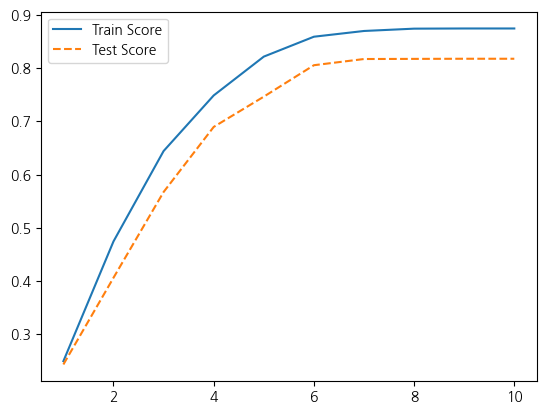

In [14]:
plt.plot(para_depth, train_score, linestyle = '-', label = 'Train Score')
plt.plot(para_depth, test_score, linestyle = '--', label = 'Test Score')
plt.legend()

깊이는 7부터 거의 score의 차이가 없는 것으로 보이기 때문에 7로 설정한다.

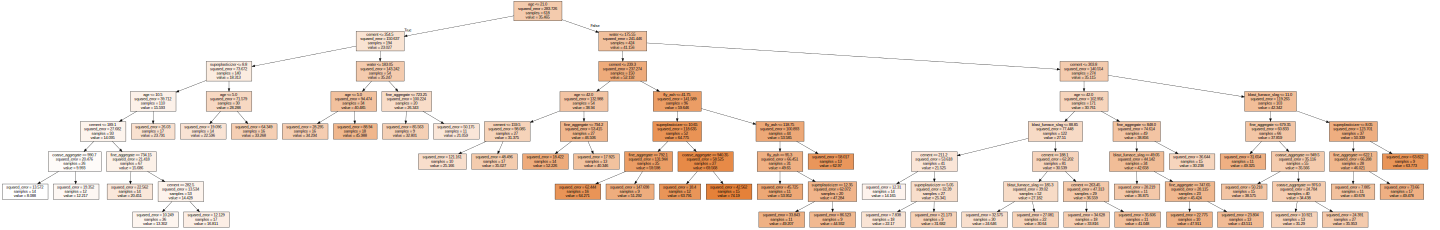

In [15]:
tree_graph = DecisionTreeRegressor(random_state = 1234, min_samples_leaf = 9, min_samples_split = 20,
                                  max_depth = 7)
tree_graph.fit(df_train_x, df_train_y)
export_graphviz(tree_graph, out_file = 'tree_depth.dot',
               feature_names = v_feature_name, impurity = True, filled= True)
with open('tree_depth.dot') as f:
    dot_graph = f.read()

pdot = pydot.graph_from_dot_data(dot_graph)
# Access element [0] because graph_from_dot_data actually returns a list of DOT elements.
pdot[0].set_graph_defaults(size = "\"20,20\"")
graph = Source(pdot[0].to_string())
graph

In [16]:
tree_final = DecisionTreeRegressor(min_samples_leaf = 9, min_samples_split = 20, max_depth = 7, random_state= 1234)
tree_final.fit(df_train_x, df_train_y)

DecisionTreeRegressor(max_depth=7, min_samples_leaf=9, min_samples_split=20,
                      random_state=1234)

In [17]:
df_importance = pd.DataFrame()
df_importance['Feature'] = v_feature_name
df_importance['Importance'] = tree_final.feature_importances_

df_importance.sort_values('Importance', ascending = False, inplace = True)
df_importance.round(3)

,Feature,Importance
7,age,0.359
0,cement,0.257
3,water,0.202
4,superplasticizer,0.052
6,fine_aggregate,0.046
1,blast_furnace_slag,0.045
2,fly_ash,0.032
5,coarse_aggregate,0.008


Text(0, 0.5, '변수')

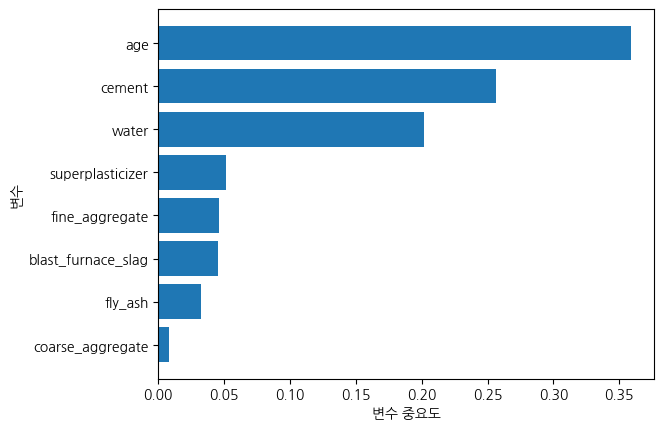

In [18]:
df_importance.sort_values('Importance', ascending = True, inplace = True)
coordinates = range(len(df_importance))
plt.barh(y = coordinates, width = df_importance['Importance'])
plt.yticks(coordinates, df_importance['Feature'])
plt.xlabel('변수 중요도')
plt.ylabel('변수')

전체적으로 봤을 때 콘크리트의 강도는 age, cement, water 변수가 큰 영향을 미치는 것으로 보인다.

criterion을 'squared_error'로 바꿔서 예측해보자.

In [20]:
tree_uncustomized = DecisionTreeRegressor(criterion = 'squared_error',random_state = 1234)
tree_uncustomized.fit(df_train_x, df_train_y)

print('Score on training set: {:.3f}'.format(tree_uncustomized.score(df_train_x, df_train_y)))
print('Score on test set: {:.3f}'.format(tree_uncustomized.score(df_test_x, df_test_y)))


Score on training set: 0.996
Score on test set: 0.790


criterion이 'squared_error'인 경우  
Score on training set: 0.996  
Score on test set: 0.790  
다음과 같이 나왔는데, 기본 모델의 경우 mae의 성능이 조금 더 좋은 것을 알 수 있다.

In [22]:
train_score = []
test_score = []

for v_min_samples_leaf in para_leaf:
    tree2= DecisionTreeRegressor(criterion = 'squared_error', random_state = 1234, min_samples_leaf = v_min_samples_leaf)
    
    tree2.fit(df_train_x, df_train_y)
    train_score.append(tree2.score(df_train_x, df_train_y))
    test_score.append(tree2.score(df_test_x, df_test_y))
    
df_score_leaf = pd.DataFrame()
df_score_leaf['MinSamplesLeaf'] = para_leaf
df_score_leaf['TrainScore'] = train_score
df_score_leaf['TestScore'] = test_score

df_score_leaf.round(3)

,MinSamplesLeaf,TrainScore,TestScore
0,1,0.996,0.790
1,2,0.978,0.783
2,3,0.959,0.786
3,4,0.943,0.796
4,5,0.934,0.811
5,6,0.920,0.810
6,7,0.909,0.799
7,8,0.900,0.792
8,9,0.877,0.817
9,10,0.868,0.816


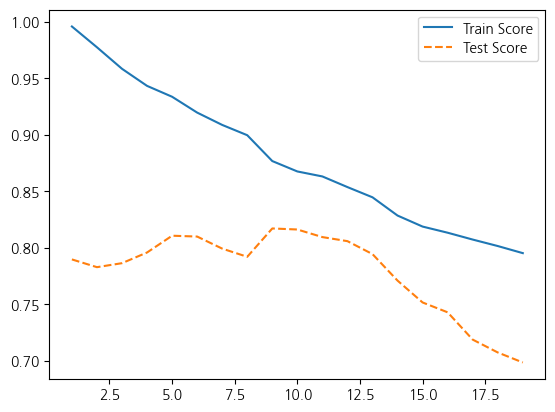

In [23]:
plt.plot(para_leaf, train_score, linestyle = '-', label = 'Train Score')
plt.plot(para_leaf, test_score, linestyle = '--', label = 'Test Score')
plt.legend()

mae의 경우 mse보다 leaf node의 데이터 수를 증가시킬 경우 test score가 많이 떨어져 leaf node의 데이터 수는 3으로 설정한다.

In [24]:
train_score = []
test_score = []

para_split = [n_split * 2 for n_split in range(2, 20)]

for v_min_samples_split in para_split:
    tree2= DecisionTreeRegressor(criterion = 'squared_error', random_state = 1234, min_samples_leaf = 3,
                               min_samples_split = v_min_samples_split)
    
    tree2.fit(df_train_x, df_train_y)
    train_score.append(tree2.score(df_train_x, df_train_y))
    test_score.append(tree2.score(df_test_x, df_test_y))
    
df_score_split = pd.DataFrame()
df_score_split['MinSmaplesSplit'] = para_split
df_score_split['TrainScore'] = train_score
df_score_split['TestScore'] = test_score

df_score_split.round(3)

,MinSmaplesSplit,TrainScore,TestScore
0,4,0.959,0.786
1,6,0.959,0.786
2,8,0.954,0.790
3,10,0.947,0.803
4,12,0.938,0.791
5,14,0.926,0.810
6,16,0.917,0.786
7,18,0.903,0.793
8,20,0.898,0.798
9,22,0.890,0.798


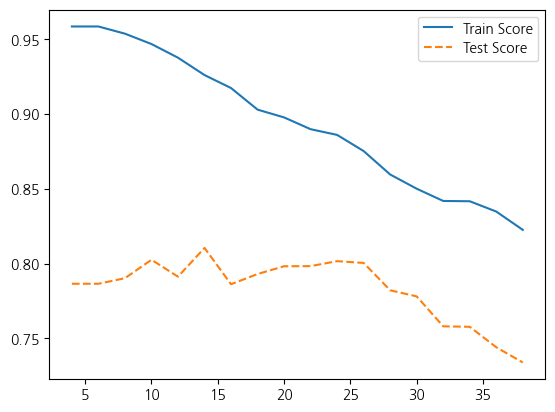

In [25]:
plt.plot(para_split, train_score, linestyle = '-', label = 'Train Score')
plt.plot(para_split, test_score, linestyle = '--', label = 'Test Score')
plt.legend()

split node의 데이터 수는 그래프에서 test score가 증가하는 구간인 12로 설정한다.

In [26]:
train_score = []
test_score = []

para_depth = [depth for depth in range(1, 11)]

for v_max_depth in para_depth:
    tree2= DecisionTreeRegressor(criterion = 'squared_error', random_state = 1234, min_samples_leaf = 3,
                               min_samples_split = 12, max_depth = v_max_depth)
    
    tree2.fit(df_train_x, df_train_y)
    train_score.append(tree2.score(df_train_x, df_train_y))
    test_score.append(tree2.score(df_test_x, df_test_y))
    
df_score_depth = pd.DataFrame()
df_score_depth['Depth'] = para_depth
df_score_depth['TrainScore'] = train_score
df_score_depth['TestScore'] = test_score

df_score_depth.round(3)

,Depth,TrainScore,TestScore
0,1,0.249,0.243
1,2,0.474,0.406
2,3,0.644,0.567
3,4,0.749,0.671
4,5,0.832,0.732
5,6,0.886,0.783
6,7,0.917,0.803
7,8,0.929,0.810
8,9,0.935,0.793
9,10,0.937,0.802


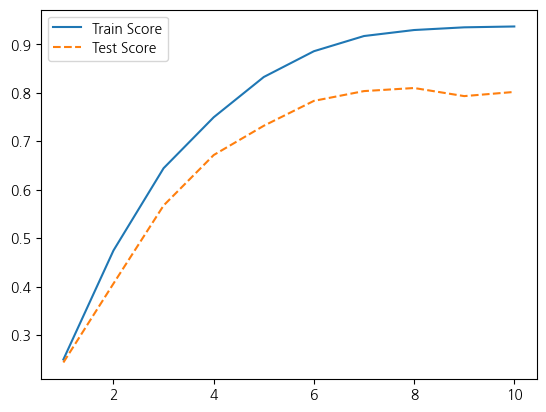

In [27]:
plt.plot(para_depth, train_score, linestyle = '-', label = 'Train Score')
plt.plot(para_depth, test_score, linestyle = '--', label = 'Test Score')
plt.legend()

depth는 성능이 가장 우수한 9로 설정한다.

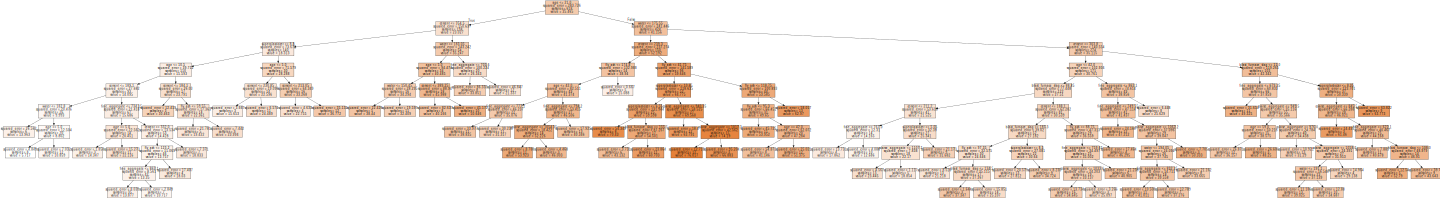

In [28]:
tree_graph = DecisionTreeRegressor(criterion = 'squared_error', random_state = 1234, min_samples_leaf = 3, min_samples_split = 14,
                                  max_depth = 9)
tree_graph.fit(df_train_x, df_train_y)
export_graphviz(tree_graph, out_file = 'mae_tree_depth.dot',
               feature_names = v_feature_name, impurity = True, filled= True)
with open('mae_tree_depth.dot') as f:
    dot_graph = f.read()
pdot = pydot.graph_from_dot_data(dot_graph)
# Access element [0] because graph_from_dot_data actually returns a list of DOT elements.
pdot[0].set_graph_defaults(size = "\"20,20\"")
graph = Source(pdot[0].to_string())
graph

GridSearchCV로 mse를 기준으로 했을 때 최적 값

In [32]:
estimator = DecisionTreeRegressor()

param_grid = {'criterion': ['squared_error'], 'max_features': ['auto', 'sqrt', 'log2'],
             'max_depth': para_depth, 'min_samples_split': para_split,
             'min_samples_leaf': para_leaf}

# scoring = 'r2' -> 결정계수로 scoring
grid_dt = GridSearchCV(estimator, param_grid, scoring = 'r2', n_jobs = -1)
grid_dt.fit(df_train_x, df_train_y)


print('best estimator model: \n{}'.format(grid_dt.best_estimator_))
print('\nbest parameter: \n{}'.format(grid_dt.best_params_))
print('\nbest score: \n{}'.format(grid_dt.best_score_.round(3)))

C:\Users\winju\Anaconda\envs\lab4\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
17100 fits failed out of a total of 51300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
8878 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\winju\Anaconda\envs\lab4\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\winju\Anaconda\envs\lab4\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\winju\Anaconda\envs\lab4\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File 

best estimator model: 
DecisionTreeRegressor(max_depth=8, max_features='log2', min_samples_split=8)

best parameter: 
{'criterion': 'squared_error', 'max_depth': 8, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 8}

best score: 
0.75


C:\Users\winju\Anaconda\envs\lab4\lib\site-packages\sklearn\model_selection\_search.py:979: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.55826509 0.55052003 0.5464025 ]
  warnings.warn(


mse를 기준으로 했을 때, 파라미터 선택이 최적의 선택과 차이가 꽤 큰 것을 볼 수 있다.

GridSearchCV로 mae를 기준으로 했을 때 최적 값

In [33]:
estimator = DecisionTreeRegressor()

param_grid = {'criterion': ['absolute_error'], 'max_features': ['auto', 'sqrt', 'log2'],
             'max_depth': para_depth, 'min_samples_split': para_split,
             'min_samples_leaf': para_leaf}

# scoring = 'r2' -> 결정계수로 scoring
grid_dt = GridSearchCV(estimator, param_grid, scoring = 'r2', n_jobs = -1)
grid_dt.fit(df_train_x, df_train_y)


print('best estimator model: \n{}'.format(grid_dt.best_estimator_))
print('\nbest parameter: \n{}'.format(grid_dt.best_params_))
print('\nbest score: \n{}'.format(grid_dt.best_score_.round(3)))

C:\Users\winju\Anaconda\envs\lab4\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
17100 fits failed out of a total of 51300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
16041 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\winju\Anaconda\envs\lab4\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\winju\Anaconda\envs\lab4\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\winju\Anaconda\envs\lab4\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File

best estimator model: 
DecisionTreeRegressor(criterion='absolute_error', max_depth=7,
                      max_features='log2', min_samples_leaf=3,
                      min_samples_split=14)

best parameter: 
{'criterion': 'absolute_error', 'max_depth': 7, 'max_features': 'log2', 'min_samples_leaf': 3, 'min_samples_split': 14}

best score: 
0.744


C:\Users\winju\Anaconda\envs\lab4\lib\site-packages\sklearn\model_selection\_search.py:979: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.50867824 0.56648601 0.54292969]
  warnings.warn(


> 결론  
mse  
콘크리트의 강도를 가장 강하게 하고 싶다면, age > 21이면서 water < 175.55 이고 cement > 239.3 여야 한다. cement > 239.3 이면서 fly_ash < 41.75 인 경우 mse가 100이상 떨어지는데 이때 fly_ash 변수가 중요하게 작용하는 것을 알 수 있다. 또한 superplasticizer > 10.65 이면서 course_aggregate < 940.35 인 경우 콘크리트 강도가 74.19로 가장 큰 것을 알 수 있다. 다만, 이 모델의 경우 mse가 여전히 크기 때문에 그렇게 좋은 모델이라고 할 수 없을 것 같다.  
<br>
mae  
mae를 기준으로 예측했을 경우 가장 센 콘크리트 강도는 79.3이다. 이때 mae = 1.42로 모델 성능이 매우 좋은 것을 볼 수 있다.
<br><br>
mse를 기준으로 했을 때 최대 콘크리트 강도 경로    
age > 21, water < 175.55, cement > 239.3, fly_ash < 41.75, superplasticizer > 10.65, course_aggregate > 940.35  
<br>
mae를 기준으로 했을 때 최대 콘크리트 강도 경로    
age > 21, water < 175.55, cement > 313.15, fly_ash <=29.5, 
coarse_aggregate > 940.35, water <= 169, age > 73.5
<br><br>
두 경로가 fly_ash부터 차이나는 것을 볼 수 있다. GridSearch에서도 봤듯이 mse의 파라미터 선택을 잘못해서 발생한 차이라고 생각해서 최적의 파라미터로 다시 한 번 비교해보았다.

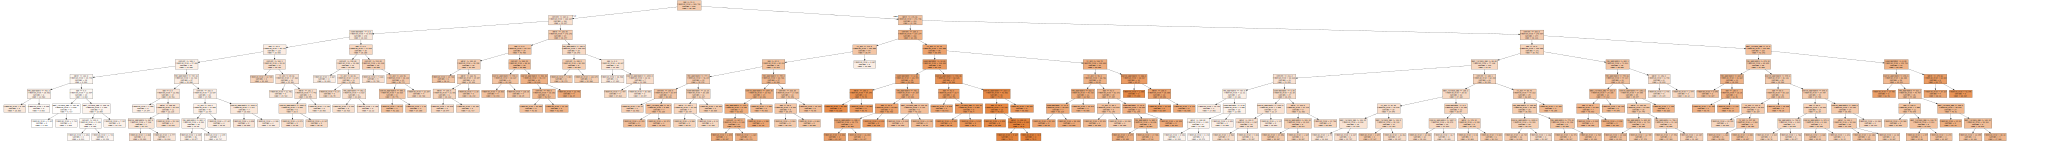

In [34]:
tree_graph = DecisionTreeRegressor(criterion = 'friedman_mse', random_state = 1234, min_samples_leaf = 3, min_samples_split = 4,
                                  max_depth = 9)
tree_graph.fit(df_train_x, df_train_y)
export_graphviz(tree_graph, out_file = 'mse_tree_depth.dot',
               feature_names = v_feature_name, impurity = True, filled= True)
with open('mse_tree_depth.dot') as f:
    dot_graph = f.read()
pdot = pydot.graph_from_dot_data(dot_graph)
# Access element [0] because graph_from_dot_data actually returns a list of DOT elements.
pdot[0].set_graph_defaults(size = "\"40,40\"")
graph = Source(pdot[0].to_string())
graph


><br><br>
mse를 기준으로 했을 때 최대 콘크리트 강도 경로    
age > 21, water < 175.55, cement > 219.3, fly_ash <=41.75, 
superplasticizer > 10.65, coarse_aggregate > 940.35, 
coarse_aggregate <= 1017.3, age > 73.5, water > 156.15   
-> strength = 79.3, mse =  0.0
<br><br>
mae를 기준으로 했을 때 최대 콘크리트 강도 경로    
age > 21, water < 175.55, cement > 313.15, fly_ash <=29.5, 
coarse_aggregate > 940.35, water <= 169, age > 73.5  
-> strength = 79.3, mae = 1.42  
<br><br>
mse 기준을 최적 파라미터로 바꿨더니 조금 다르긴 하지만 일정부분에서 경로가 만나는 것을 확인 할 수 있다.